<a href="https://colab.research.google.com/github/MrSupiri/lazy-koala/blob/proof-of-concept/Lazy_Koala_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lazy Koala - Proof of concept

To prove my norval approach detecting anomalies in time series dataset I first need to

1.   Create time series dataset
2.   Insert anomalies to the dataset and create labels
3.   Run it againest a traditional anomaly detection algorithms (ML)
4.   Run it againest a RNN (current standard)
5.   Run is againest a CNN (norval approach)
6.   Show proofs CNN is better atleast in one metric so it's viable approach



## Create time series dataset

There 2 main requirements when creating the time series dataset.
1. It need to complex enough so that using ML/DL make sense
2. There should be pattern, Models won't able to find anomalies in completly random distributions becouse every data point is anomaly.

So to do this I am gonna take sin curve and introduce a random fluctuation. Sin funcation introduce a pattern to the dataset while the random fluctuation make it so it's not very easy understand the pattern.

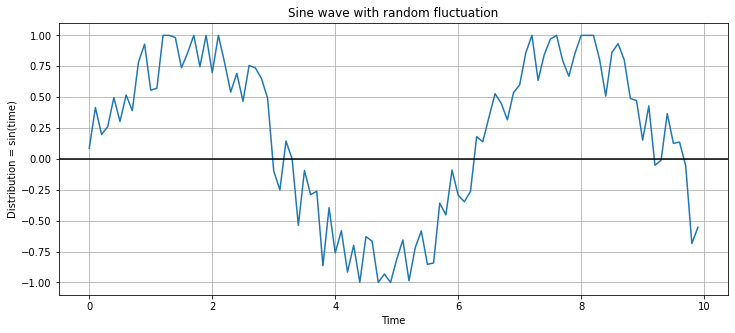

In [ ]:
import numpy as np
import matplotlib.pyplot as plot

# Get x values of the sine wave
time = np.arange(0, 500, 0.1)
# Amplitude of the sine wave is sine of a variable like time
amplitude = np.sin(time)
# random series of number that fluctuate between -0.3 and +0.3
fluctuation = np.random.uniform(-0.35, 0.35, len(time))
# combined both of them and clip it for good measures so it won't go beyond 1 and below -1
distribution = np.clip(amplitude + fluctuation, -1, 1)
# Plot a sine wave using time and amplitude obtained for the sine wave
plot.figure(figsize=(12, 5))
plot.plot(time[:100], distribution[:100])
# Give a title for the sine wave plot
plot.title('Sine wave with random fluctuation')
# Give x axis label for the sine wave plot
plot.xlabel('Time')
# Give y axis label for the sine wave plot
plot.ylabel('Distribution = sin(time)')
plot.grid(True, which='both')
plot.axhline(y=0, color='k')
plot.show()


## Insert anomalies to the dataset and create labels

requirements:
1. We should be able to create random anomalies which spans for multiple timestamps
2. We should be able to recoard these anomalies so we can train a model to detect them

In [ ]:
# import random

# def create_anomaly(series, start, end):
#     start = start * 10
#     end = min(len(series), end * 10)
#     if end > start:
#         random_distribution = np.random.uniform(-1, 1, end-start)
#         series[start:end] = random_distribution
#     return series

# i = 0
# anomalies = []
# anomaly_distribution = distribution.copy()

# while i < len(distribution):
#     size = random.randint(1,3)
#     if random.randint(0,10) == 5:
#         anomaly_distribution = create_anomaly(anomaly_distribution, i, i+size)
#         i += size
#         anomalies += [True] * size
#     else:
#         i +=1
#         anomalies.append(False)

# plot.plot(time, anomaly_distribution)
# # Give a title for the sine wave plot
# plot.title('distribution with a random anomaly')
# # Give x axis label for the sine wave plot
# plot.xlabel('Time')
# # Give y axis label for the sine wave plot
# plot.ylabel('Distribution = sin(time)')
# plot.grid(True, which='both')
# plot.axhline(y=0, color='k')
# plot.show()
# # Display the sine wave
# for k in range(0, len(anomalies), 10):
#     print(anomalies[k:k+10])

# Model to prove the concept

My project revolves around a concept of anomaly detection by predicting expected future and compare with reality.

### Predict the future
To predict the future from past data (AKA do regression) I came up with a standard multilayer perceptron (MLP) with a bottlneck layer in the middle. Becouse there is bottleneck layer in the middle, model has to figure out a deeper meaning behind the data so it can successfully produced the expected output.

This Model is silghtly modified version of AutoEncoder.

This Model take the 48 data points time series as the `INPUT` and next 10 data points as the `OUTPUT`.

So it's job is to given the past 48 data points predict the next 10 data points.


In [ ]:
import keras
from keras import layers

input = keras.Input(shape=(48,))
encoded = layers.Dense(24, activation='relu')(input)
encoded = layers.Dense(12, activation='relu')(encoded)
encoded = layers.Dense(6, activation='relu')(encoded)
encoded = layers.Dense(4, activation='relu')(encoded)
decoded = layers.Dense(6, activation='relu')(encoded)
decoded = layers.Dense(8, activation='relu')(encoded)
decoded = layers.Dense(10, activation='linear')(decoded)

autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48)]              0         
_________________________________________________________________
dense (Dense)                (None, 24)                1176      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                90    

# Create the Inputs and Outputs

On the first setup in this notebook, I took a sine wave and added bit of noise to it so it's can not be modeled very easily.

So Now we need to take that time series data sets and chunk them into `INPUTS` and `OUTPUTS`.

To do that, I put all the values from the noisy sine wave to list and iterated over it. 

While iterating,
- I took the current index of the list and add 48 to it.
- Then used those 2 values to create a sublist and added to `INPUTS`
- Then I took the 10 data points after those values and added to `OUTPUTS`
- Then I repeated the whole processes till either the sub list `INPUT` or `OUTPUT` doesn't satisfy required input or output size.

Then did few preprocessing to make sure data is in right shape so the model can parse it.

In [ ]:
X = []
Y = []

batch_size = 48
predict_size = 10

for i in range(len(distribution)):
    _x = distribution[i:i+batch_size]
    _y = distribution[i+batch_size:i+batch_size+predict_size]
    if len(_y) < predict_size or len(_x) < batch_size:
        break
    X.append(np.array(_x).astype('float32'))
    Y.append(np.array(_y).astype('float32'))

X = np.array(X).reshape([-1, batch_size])
Y = np.array(Y).reshape([-1, predict_size])

print(X.shape)
print(Y.shape)

(4943, 48)
(4943, 10)


# Training

After I had the `INPUTS` and `OUTPUTS`. I used scikit learn's `train_test_split` function to split the data by 8:2 for training and testing

Then I trained the model with those data for 20 rounds

Important note: Becouse I am using sequence dataset, I kept shuffling off so the model will try to adapt to patterns between outside of the INPUTs and OUTPUTs

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

history = autoencoder.fit(X_train, y_train,
                epochs=20,
                shuffle=False,   
                validation_data=(X_test, y_test))

Epoch 1/20
124/124 [==============================] - 12s 6ms/step - loss: 0.4290 - val_loss: 0.2452
Epoch 2/20
124/124 [==============================] - 0s 2ms/step - loss: 0.1942 - val_loss: 0.0892
Epoch 3/20
124/124 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0491
Epoch 4/20
124/124 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0423
Epoch 5/20
124/124 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0393
Epoch 6/20
124/124 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0376
Epoch 7/20
124/124 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0364
Epoch 8/20
124/124 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0357
Epoch 9/20
124/124 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0352
Epoch 10/20
124/124 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.034

# Testing

From here out I am doing few testing to see if Model is performing all right

## Compare the Model's output the the real data

Note - Here I am testing the model with it's training data which isn't good but for POC this won't be that bad

In [ ]:
testing_sample = 72

prediction = autoencoder.predict(np.array(X[testing_sample-1]).reshape([1, batch_size]))

print("Model's output for 50th data point: \t", list(prediction[0]))
print("Ground truth for the 50th data point: \t", list(Y[testing_sample-1]))

Model's output for 50th data point: 	 [-0.59425336, -0.49619898, -0.45094597, -0.31312242, -0.30581614, -0.16060911, -0.095438994, 0.03752461, 0.071258485, 0.18210882]
Ground truth for the 50th data point: 	 [-0.57882965, -0.19350041, -0.1875309, -0.15566213, -0.6005762, 0.1443136, 0.13213506, 0.35971648, 0.11811984, 0.539085]


### Testing if the predictions matches the sine wave 

Here, <br>
Blue Line - Input data <br>
Green Line - Expected output (ground truth) <br>
Orange Line - Model's prediction

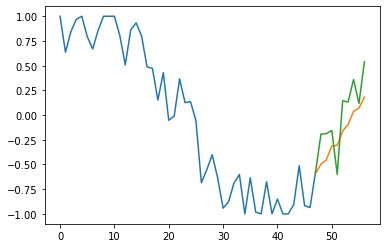

In [ ]:
plot.plot(range(48), X[testing_sample])
plot.plot(range(47,57), prediction[0])
plot.plot(range(47,57), Y[testing_sample-1])
plot.show()

### Testing if the model can recreate the entrie sine wave from it's own

#### Testing Setup
- Get one input value from training data (50 data points)
- Feed it to NN and get the output (10 data points)
- Combined those 2 (60 data points)
- Get last 50 data points (this contain data from both original input and model's output)
- Repeat this for 10 times till the models is using it's own output as the input

In [ ]:
predictions = list(X[0])

for _ in range(10):
    prediction = autoencoder.predict(np.array(predictions[-batch_size:]).reshape([1, batch_size]))[0]
    predictions += list(prediction)

ground_truth = distribution[:len(predictions)]

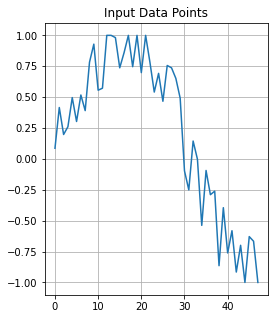

In [ ]:
plot.figure(figsize=(4, 5))
plot.plot(range(batch_size), predictions[:batch_size])
plot.title('Input Data Points')
plot.grid(True, which='both')
plot.show()

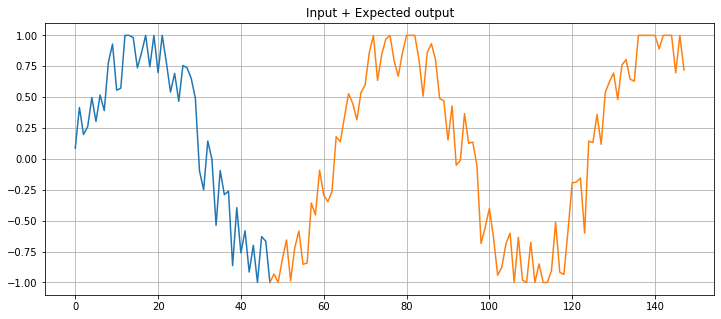

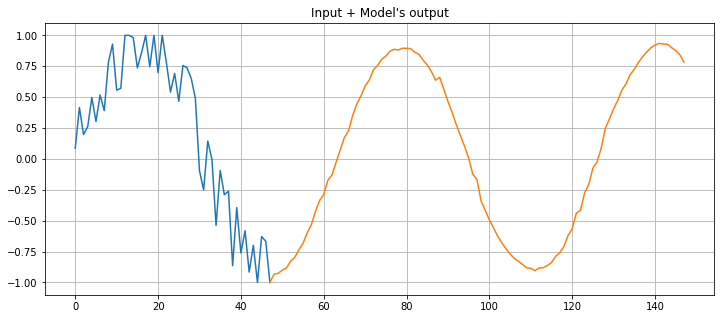

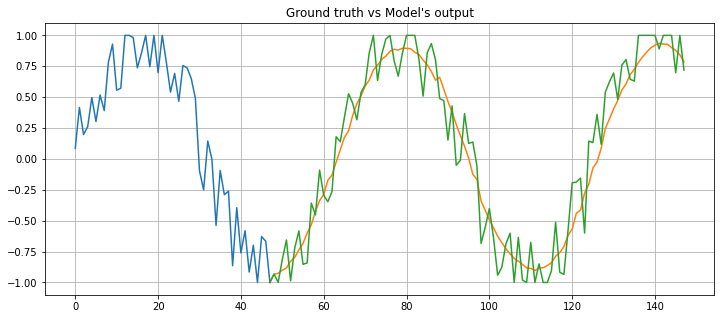

In [ ]:
plot.figure(figsize=(12, 5))
plot.plot(range(batch_size), predictions[:batch_size])
plot.plot(range(batch_size-1, len(predictions)), ground_truth[batch_size-1:])
plot.title("Input + Expected output")
plot.grid(True, which='both')
plot.show()

plot.figure(figsize=(12, 5))
plot.plot(range(batch_size), predictions[:batch_size])
plot.plot(range(batch_size-1,len(predictions)), predictions[batch_size-1:])
plot.title("Input + Model's output")
plot.grid(True, which='both')
plot.show()

plot.figure(figsize=(12, 5))
plot.plot(range(batch_size), predictions[:batch_size])
plot.plot(range(batch_size-1,len(predictions)), predictions[batch_size-1:])
plot.plot(range(batch_size-1, len(predictions)), ground_truth[batch_size-1:])
plot.title("Ground truth vs Model's output")
plot.grid(True, which='both')
plot.show()

# Conclusion

- Model was able identify there was repeating pattern
- Model was able continue the pattern only with small set of input data
- Model was able remove the noise from data set and came up with the original sine wave

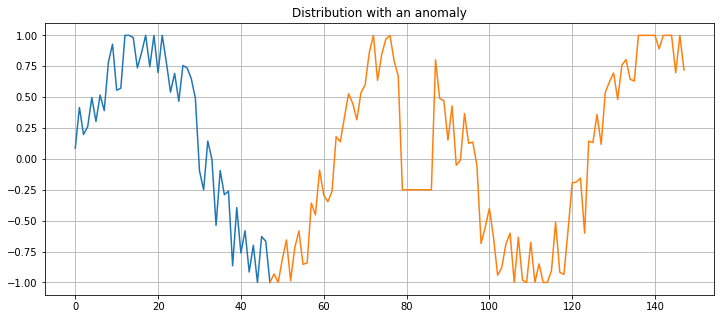

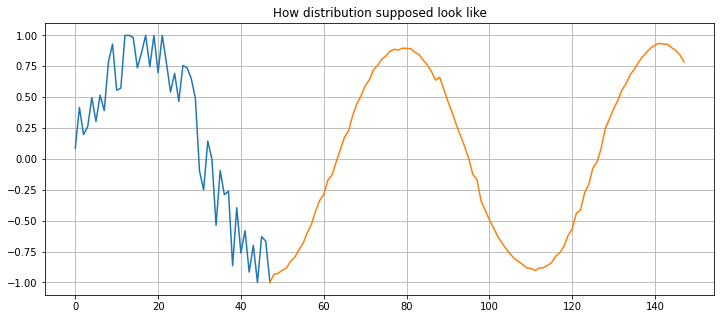

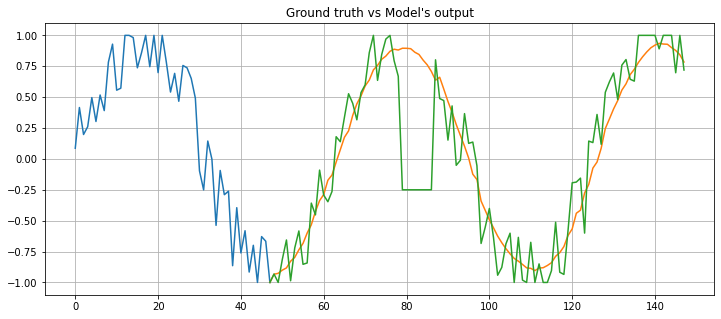

In [ ]:
ground_truth[79:87] = [-0.25] * 8

plot.figure(figsize=(12, 5))
plot.plot(range(batch_size), predictions[:batch_size])
plot.plot(range(batch_size-1, len(predictions)), ground_truth[batch_size-1:])
plot.title("Distribution with an anomaly")
plot.grid(True, which='both')
plot.show()

plot.figure(figsize=(12, 5))
plot.plot(range(batch_size), predictions[:batch_size])
plot.plot(range(batch_size-1,len(predictions)), predictions[batch_size-1:])
plot.title("How distribution supposed look like")
plot.grid(True, which='both')
plot.show()

plot.figure(figsize=(12, 5))
plot.plot(range(batch_size), predictions[:batch_size])
plot.plot(range(batch_size-1,len(predictions)), predictions[batch_size-1:])
plot.plot(range(batch_size-1, len(predictions)), ground_truth[batch_size-1:])
plot.title("Ground truth vs Model's output")
plot.grid(True, which='both')
plot.show()

# To be continued

Here is how this all fit into my service monitoring platform

- We will deploy one model for each micro service.
- That model will be able watch all the vital metrics of the particular service and predict how all those vital should looks for next 60 seconds. 
- After 60 seconds if the actual vitals and predicted vital are way off, it will issue a warning to platform engineers

## WHY?
- This will eliminate the need to hard coded metrics thresholds (ex - If memory usage is above 3GB, something is wrong)
- Help service grow,
    - For example if we have hard coded threshold, As service grow (getting more requests and adding more functions) those thresholds will met with even normal usage
- This can be reused to any time series problem with minimal transfer learning (generalized model)